In [6]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.zsoc import OCV_curve
import os

# How long for calibration
divisions = 20              # every 10 seconds
sample_rate = 5/divisions   # 1 sample per second


In [7]:
df = pd.read_csv('./res/K_para.csv')
df = df.drop(columns=['Sample No.', 'Battery Manufacturer', 'Serial Number', 'Cell Number'])
data = df.to_numpy()

# truncate off the last column (R0)
batteries = data[:, :-1]
print(batteries.shape)

(34, 8)


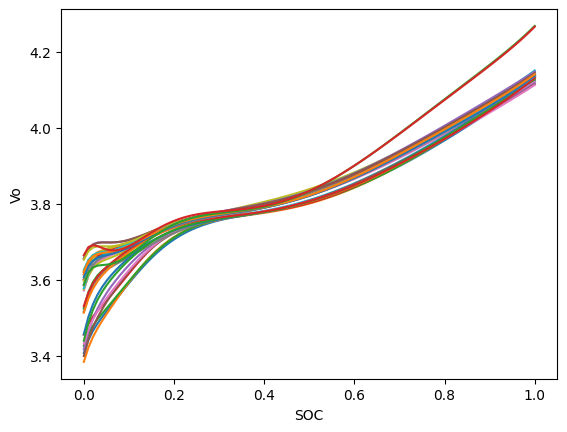

In [8]:
# generate ocv curves for each battery
# for this stage, we will just use OCV curves as input
curves_vo = []
curves_zsoc = []
for battery in batteries:
    b = OCV_curve(battery)
    plt.plot(b['zsoc'], b['Vo'])
    curves_vo.append(b['Vo'])
    curves_zsoc.append(b['zsoc'])
plt.xlabel('SOC')
plt.ylabel('Vo')
plt.show()

#

#print(curves_vo[0])
#print(curves_zsoc[0])

curves = np.array(curves_vo)

In [9]:
model = tf.keras.Sequential()
#model.add(tf.keras.layers.Conv2D(1, (1, 1), activation='relu', input_shape=(divisions, 3, 1)))
model.add(tf.keras.layers.Dense(divisions*6, activation='relu'))
model.add(tf.keras.layers.Dense(len(batteries), activation='linear'))
model.build(input_shape=(None, divisions*3))
model.compile(optimizer='adam', loss='mse', metrics=['accuracy', 'mae', 'mse'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 120)               7320      
                                                                 
 dense_3 (Dense)             (None, 34)                4114      
                                                                 
Total params: 11,434
Trainable params: 11,434
Non-trainable params: 0
_________________________________________________________________


In [10]:
import src.dataset as dataset
import time
#from tqdm import tqdm_gui
from tqdm import tqdm
#from scipy import interpolate

#import dataset cache
df = dataset.build_dataset(cache='./res/dataset.pkl')
#df.to_csv('./res/dataset.csv')

#dataset.plot_dataset(df.iloc[0], title=(str(0)+': Battery '+str(df.iloc[0]['i'])))

df = df.iloc[0:5]

training_features = []
training_labels = []
#use progress bar to show progress
for i in tqdm(range(len(df))):
    # get the min time and max time
    print(df.iloc[i]['i'])
    time_min = df.iloc[i]['t'].min()
    time_max = df.iloc[i]['t'].max()

    #make an equally spaced array of times at divisions second intervals
    time = np.linspace(time_min, time_max, int((time_max-time_min)/sample_rate))

    #interpolate the voltage and current at each time
    for j in range(len(time)):
        test_voltages = np.interp(time, df.iloc[i]['t'], df.iloc[i]['V'])
        test_currents = np.interp(time, df.iloc[i]['t'], df.iloc[i]['I'])
        #test_currents = interpolate.interp2d(test_data['t'], test_data['C'], time, kind='linear')

    #convert to pandas dataframe
    output = pd.DataFrame({'t': time, 'V': test_voltages, 'I': test_currents}).to_numpy()

    #split the data into 10 second intervals and flatten
    output = np.split(output, len(output)/divisions)
    for j in range(len(output)):
        output[j] = np.array(output[j]).flatten()
    
    #add output to training features
    training_features.append(output)
    training_labels.append(df.iloc[i]['i'])




  0%|          | 0/5 [00:00<?, ?it/s]

0


 20%|██        | 1/5 [00:09<00:38,  9.64s/it]

0


 40%|████      | 2/5 [00:19<00:28,  9.63s/it]

0


In [ ]:
print(training_labels[0])
print(training_features[0])

print(training_labels.shape)

#save the training features and labels pandas dataframes
df_training_features = pd.DataFrame(training_features)
df_training_labels = pd.DataFrame(training_labels)

#save the training features and labels to pickle files
df_training_features.to_pickle('./res/training_features.pkl')
df_training_labels.to_pickle('./res/training_labels.pkl')

